<a href="https://www.kaggle.com/code/smellytofu/delfttreescnn?scriptVersionId=171825033" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [23]:
import os
import random
from PIL import Image
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from collections import Counter
from transformers import ViTForImageClassification
from scipy import stats
from PIL import Image, ImageDraw, ImageFilter

label_to_int = {'Dood': 0, 'Goed': 1, 'Matig': 2, 'Redelijk': 3, 'Slecht': 4,'Zeer Slecht': 5 }


class CustomImageDataset(Dataset):
    def __init__(self, images, labels, transforms=None, sampling_factors=None):
        self.images = images
        self.labels = labels
        self.transforms = transforms
        self.sampling_factors = sampling_factors if sampling_factors is not None else {label: 1 for label in set(labels)}

    def __len__(self):
        # Calculate total length considering sampling factors
        total_length = 0
        for label in self.labels:
            total_length += self.sampling_factors[label]
        return total_length

    def __getitem__(self, idx):
        # Find the actual image index based on the sampling factor
        actual_idx = idx
        for i, label in enumerate(self.labels):
            if actual_idx < self.sampling_factors[label]:
                break
            actual_idx -= self.sampling_factors[label]


        image = Image.open(self.images[i])
        label = self.labels[i]

        # Process image
        if self.transforms:
            image = self.transforms(image)

        return image, label_to_int[label]

def load_images(folder_path):
    print("Loading images...")
    images = []
    labels = []
    for class_folder in os.listdir(folder_path):
        class_path = os.path.join(folder_path, class_folder)
        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path, img_file)
            images.append(img_path)
            labels.append(class_folder)
    print("Total images loaded:", len(images))
    return images, labels

def split_dataset(images, labels, train_ratio=0.6, val_ratio=0.2):
    # Split dataset into train, validation, and test
    print("Splitting dataset...")
    dataset = list(zip(images, labels))
    random.shuffle(dataset)
    train_size = int(len(dataset) * train_ratio)
    val_size = int(len(dataset) * val_ratio)
    train_set = dataset[:train_size]
    val_set = dataset[train_size:train_size + val_size]
    test_set = dataset[train_size + val_size:]
    print(f"Dataset split into {len(train_set)} training, {len(val_set)} validation, and {len(test_set)} test images.")
    return train_set, val_set, test_set

def count_class_distribution(dataset):
    class_counts = {}
    for _, label in dataset:
        class_counts[label] = class_counts.get(label, 0) + 1
    return class_counts

def calculate_sampling_factors(train_set):
    label_counts = Counter(label for _, label in train_set)
    min_samples = min(label_counts.values())
    print(min_samples)

    # Calculate sampling factor for each class
    sampling_factors = {label: round(min_samples / count) for label, count in label_counts.items()}
    return sampling_factors

def create_dataloaders(train_set, val_set, test_set, sampling_factors, batch_size):
    # Define transformations
    print("Creating dataloaders...")

    train_transforms = transforms.Compose([
        transforms.Resize(224),  # Specify size to resize to
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    val_test_transforms = transforms.Compose([
        transforms.Resize(224),  # Specify size
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])


    train_dataset = CustomImageDataset([i[0] for i in train_set], [i[1] for i in train_set], transforms=train_transforms, sampling_factors=sampling_factors)
    val_dataset = CustomImageDataset([i[0] for i in val_set], [i[1] for i in val_set], transforms=val_test_transforms)
    test_dataset = CustomImageDataset([i[0] for i in test_set], [i[1] for i in test_set], transforms=val_test_transforms)

    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    print("Dataloaders created.")
    print(len(train_loader), len(val_loader), len(test_loader))
    return train_loader, val_loader, test_loader

def calculate_samples_per_class(class_distribution):
    min_count = min(class_distribution.values())
    samples_per_class = {label_to_int[cls]: min_count // count for cls, count in class_distribution.items()}
    return samples_per_class



def load_data(folder1):
    images, labels = load_images(folder1)
    train_set, val_set, test_set = split_dataset(images, labels)

    # Print class distribution
    train_class_distribution = count_class_distribution(train_set)
    val_class_distribution = count_class_distribution(val_set)
    test_class_distribution = count_class_distribution(test_set)

    print("Training set class distribution:", train_class_distribution)
    print("Validation set class distribution:", val_class_distribution)
    print("Test set class distribution:", test_class_distribution)
    sampling_factors = {'Matig': 1, 'Redelijk': 1, 'Slecht': 1, 'Dood':1, 'Goed': 1, 'Zeer Slecht': 1}
    

    print('Sampling factors: ', sampling_factors)
    train_loader, val_loader, test_loader = create_dataloaders(train_set, val_set, test_set, sampling_factors, batch_size=8)

    return train_loader, val_loader, test_loader

In [24]:
def extract_patches(image, patch_size, stride):
    patches = []
    c, height, width = image.size()

    for y in range(0, height - patch_size[1] + 1, stride):
        for x in range(0, width - patch_size[0] + 1, stride):
            patch = image[:, y:y + patch_size[1], x:x + patch_size[0]]
            patches.append(patch)

    return patches

def train_one_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    total_correct = 0
    total_samples = 0
    all_labels = []
    all_preds = []

    progress_bar = tqdm(train_loader, desc="Training", leave=False)
    for images, labels in progress_bar:

        images = images.to(device)
        labels = labels.to(device)


        # Forward pass
        outputs = model.forward(images)


        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Statistics
        _, predicted = torch.max(outputs, 1)

        correct = (predicted == labels).sum().item()
        progress_bar.set_postfix(loss=loss.item(), accuracy=correct/len(labels))

        total_loss += loss.item()
        total_correct += correct
        total_samples += labels.size(0)

        # For F1 score calculation
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

    avg_loss = total_loss / len(train_loader)
    accuracy = total_correct / total_samples
    f1 = f1_score(all_labels, all_preds, average='weighted')
    per_class_f1 = f1_score(all_labels, all_preds, average=None)

    return avg_loss, accuracy, f1, per_class_f1



def validate_or_test(model, loader, criterion, device, patch_size, stride, desc='Val'):
    model.eval()
    total_loss = 0
    total_samples = 0
    all_labels = []
    all_preds = []

    progress_bar = tqdm(loader, desc=desc, leave=False)
    with torch.no_grad():
        for images, labels in progress_bar:
            images = images.to(device)
            labels = labels.to(device)
            batch_preds = []

            for image in images:
                # Apply sliding window approach
                patches = extract_patches(image, patch_size, stride)
                patches = torch.stack(patches).to(device)

                # Aggregate predictions for each patch
                patch_outputs = model(patches)

                # Calculate mode for each patch prediction
                modes, _ = torch.mode(patch_outputs, dim=0)
                batch_preds.append(modes)

            batch_preds = torch.stack(batch_preds)
            loss = criterion(batch_preds, labels)
            total_loss += loss.item()

            _, predicted = torch.max(batch_preds, 1)
            total_samples += labels.size(0)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

            # Update progress bar
            progress_bar.set_postfix(loss=loss.item())

    avg_loss = total_loss / len(loader)
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    per_class_f1 = f1_score(all_labels, all_preds, average=None)

    conf_matrix = confusion_matrix(all_labels, all_preds)
    conf_matrix_percentage = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix_percentage, annot=True, fmt='g', cmap='Blues')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()
    return avg_loss, accuracy, f1, per_class_f1

def train_and_evaluate(model, train_loader, val_loader, test_loader, model_name, num_epochs, patch_size=(224, 224), stride=30):
    # Criterion, Optimizer, and Scheduler
    weight_decay=0.01 #L2 Optimisation
    lr=2e-4
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr,weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

    global best_val_f1
    global best_model_weights

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    for epoch in range(num_epochs):
        train_loss, train_accuracy, train_f1, train_f1_per_class = train_one_epoch(model, train_loader, criterion, optimizer, device)
        print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.4f}, F1 Score: {train_f1:.4f}')
        print(f'Train F1 Score Per Class ', train_f1_per_class)

        val_loss, val_accuracy, val_f1, val_f1_per_class = validate_or_test(model, val_loader, criterion, device, patch_size, stride, desc='Val')
        print(f'Epoch {epoch+1}, Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}, F1 Score: {val_f1:.4f}')
        print(f'Val F1 Score Per Class ', val_f1_per_class)
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            best_model_weights = model.state_dict()  # Save the best model weights

        # Save intermediate model weights
        torch.save(model.state_dict(), '/kaggle/working/model_state.pth')

        scheduler.step()


        test_loss, test_accuracy, test_f1, test_f1_per_class = validate_or_test(model, test_loader, criterion, device, patch_size, stride, desc='Test')
        print(f'Test Loss: {test_loss:.3f}, Accuracy: {test_accuracy:.3f}, F1 Score: {test_f1:.3f}, F1 Score Per Class [{test_f1_per_class[0]:.3f}')
        print(f'Test F1 Score Per Class ', test_f1_per_class)

    # After training is complete, load the best model weights
    model.load_state_dict(best_model_weights)

    # Save the best model weights
    torch.save(model.state_dict(), '/kaggle/working/best_model_state.pth')
    return model

Loading images...
Total images loaded: 10479
Splitting dataset...
Dataset split into 6287 training, 2095 validation, and 2097 test images.
Training set class distribution: {'Matig': 1029, 'Zeer Slecht': 1021, 'Dood': 1046, 'Redelijk': 1040, 'Slecht': 1063, 'Goed': 1088}
Validation set class distribution: {'Goed': 323, 'Matig': 370, 'Dood': 349, 'Redelijk': 350, 'Slecht': 351, 'Zeer Slecht': 352}
Test set class distribution: {'Goed': 340, 'Matig': 352, 'Dood': 356, 'Zeer Slecht': 351, 'Slecht': 337, 'Redelijk': 361}
Sampling factors:  {'Matig': 1, 'Redelijk': 1, 'Slecht': 1, 'Dood': 1, 'Goed': 1, 'Zeer Slecht': 1}
Creating dataloaders...
Dataloaders created.
786 262 263


Epoch 1, Train Loss: 1.4743, Accuracy: 0.3044, F1 Score: 0.2976
Train F1 Score Per Class  [0.22980432 0.18390805 0.56633319 0.3327787  0.20309811 0.27991718]


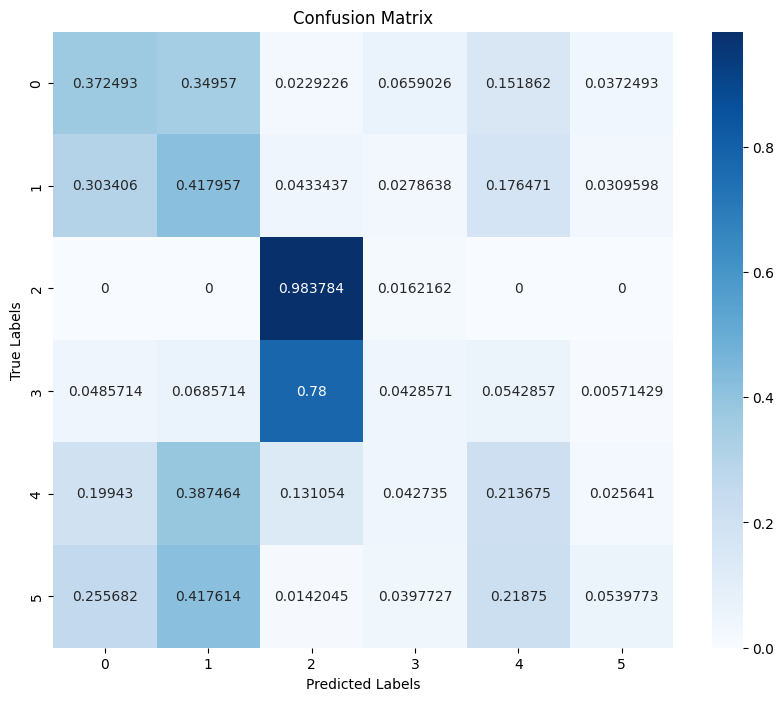

Epoch 1, Validation Loss: 1.3945, Accuracy: 0.3523, F1 Score: 0.2906
Val F1 Score Per Class  [0.34482759 0.30439684 0.67407407 0.06944444 0.23734177 0.09382716]


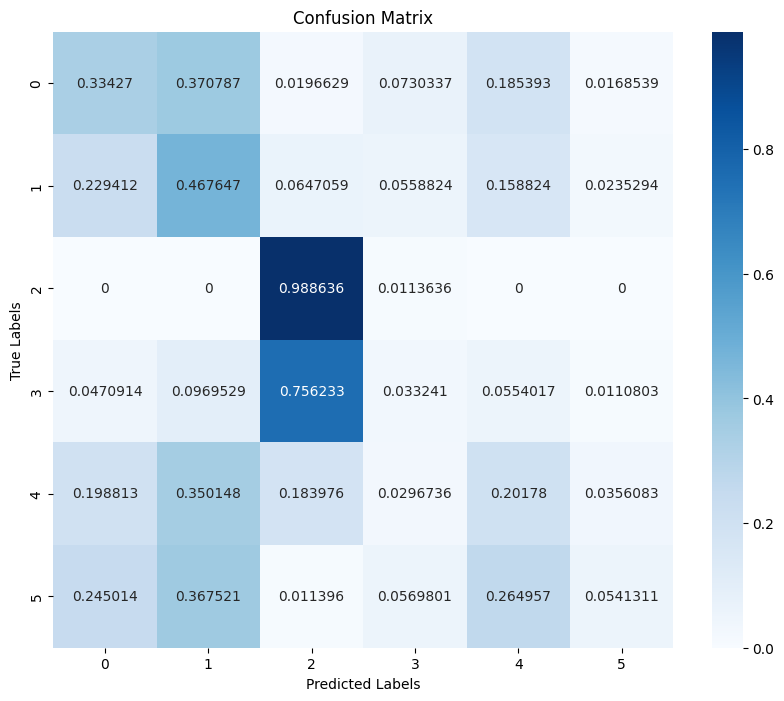

Test Loss: 1.435, Accuracy: 0.346, F1 Score: 0.281, F1 Score Per Class [0.329
Test F1 Score Per Class  [0.32918396 0.3483023  0.65168539 0.05309735 0.21316614 0.095     ]


Epoch 2, Train Loss: 1.3855, Accuracy: 0.3436, F1 Score: 0.3220
Train F1 Score Per Class  [0.30300273 0.23390005 0.62897265 0.24135682 0.24016563 0.29328622]


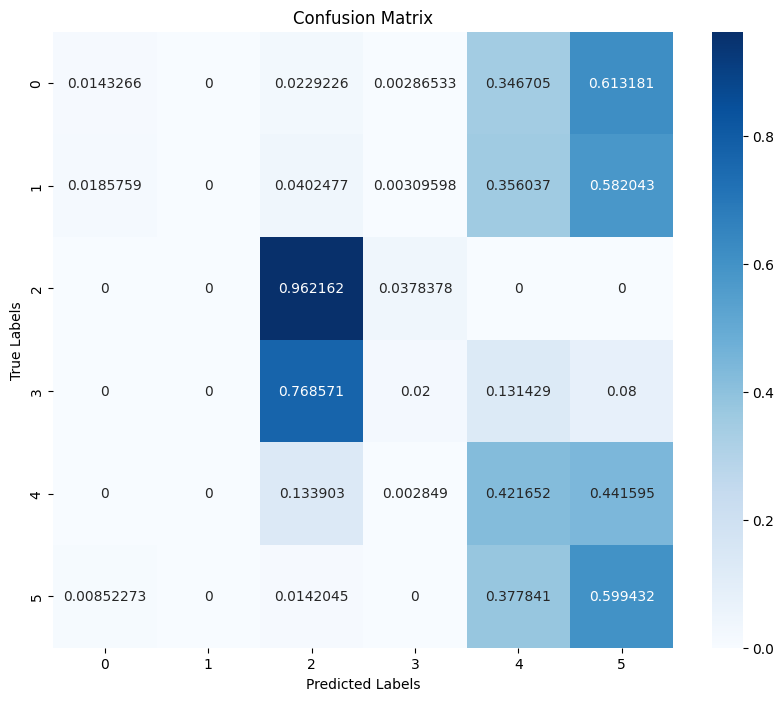

Epoch 2, Validation Loss: 1.3833, Accuracy: 0.3470, F1 Score: 0.2446
Val F1 Score Per Class  [0.02754821 0.         0.66666667 0.03743316 0.3238512  0.36759582]


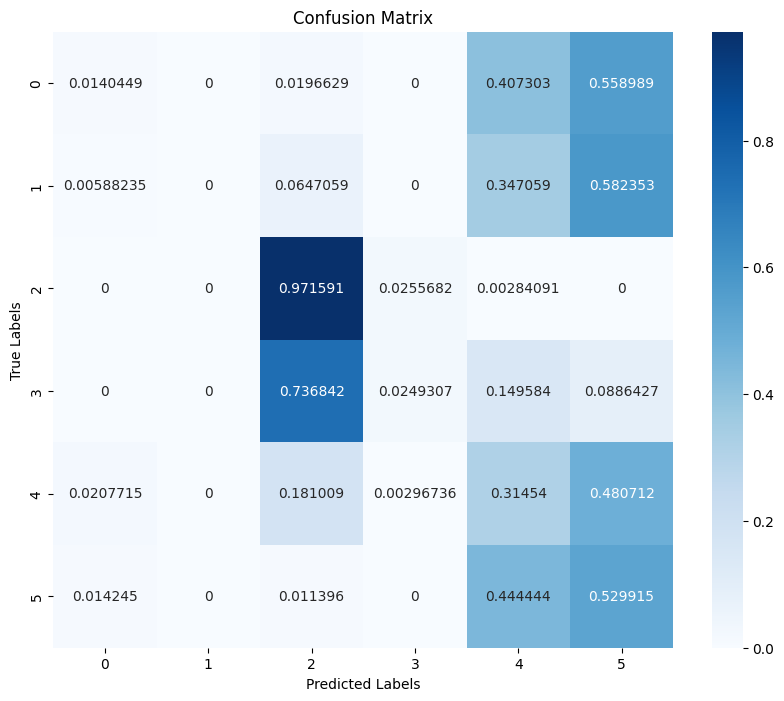

Test Loss: 1.431, Accuracy: 0.309, F1 Score: 0.214, F1 Score Per Class [0.027
Test F1 Score Per Class  [0.02666667 0.         0.64895636 0.04736842 0.23118866 0.32978723]


Epoch 3, Train Loss: 1.3755, Accuracy: 0.3518, F1 Score: 0.3216
Train F1 Score Per Class  [0.35458167 0.18148375 0.63302091 0.21139327 0.25854801 0.30091921]


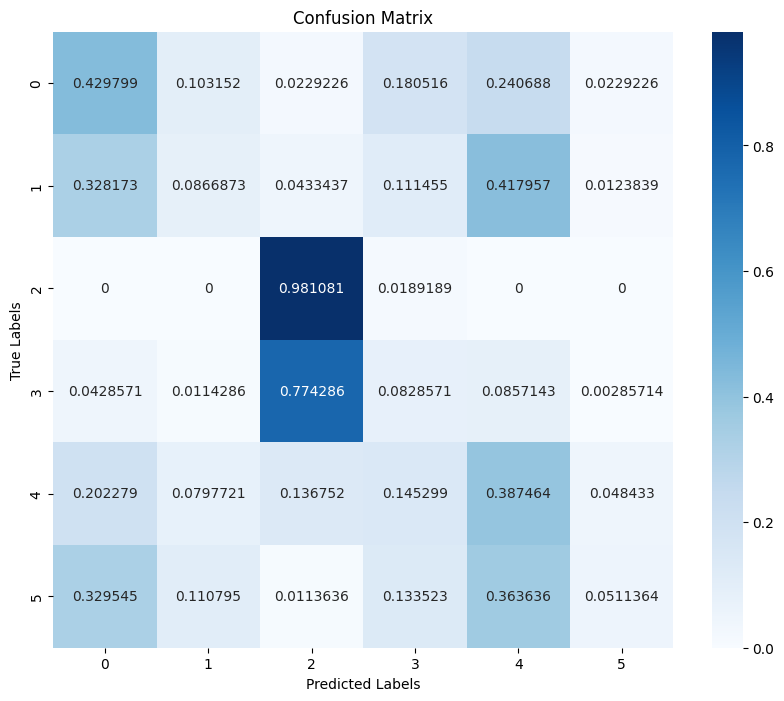

Epoch 3, Validation Loss: 1.3921, Accuracy: 0.3456, F1 Score: 0.2842
Val F1 Score Per Class  [0.37174721 0.12227074 0.67346939 0.09948542 0.31481481 0.09      ]


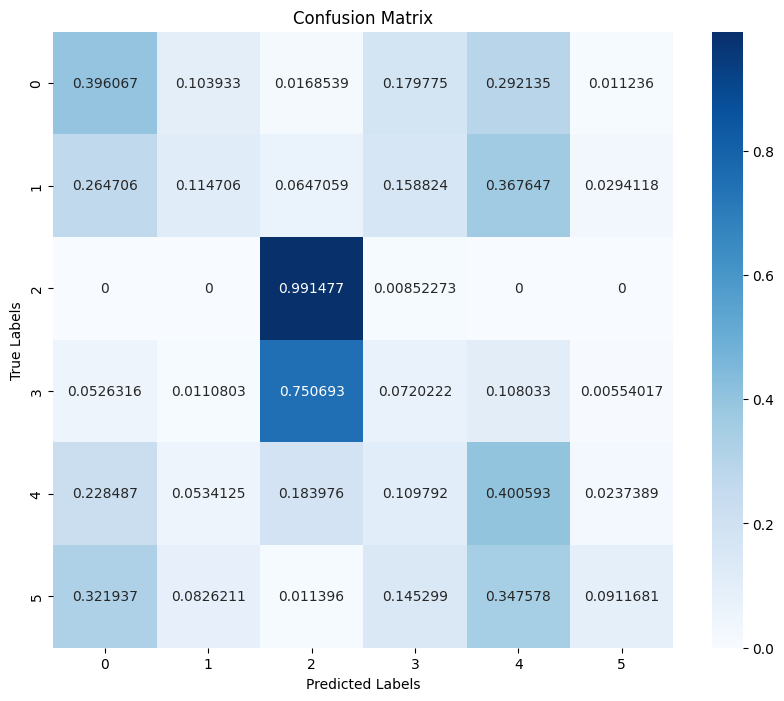

Test Loss: 1.428, Accuracy: 0.344, F1 Score: 0.289, F1 Score Per Class [0.354
Test F1 Score Per Class  [0.35427136 0.16702355 0.65478424 0.08724832 0.31322506 0.15724816]


Epoch 4, Train Loss: 1.3609, Accuracy: 0.3553, F1 Score: 0.3276
Train F1 Score Per Class  [0.37080868 0.18607443 0.63041881 0.23246493 0.27045236 0.28516378]


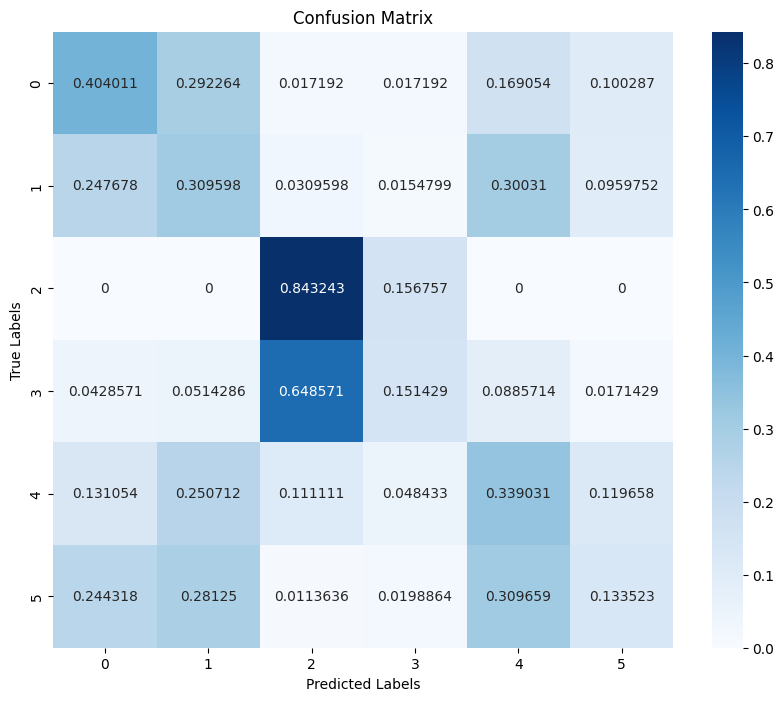

Epoch 4, Validation Loss: 1.3458, Accuracy: 0.3685, F1 Score: 0.3402
Val F1 Score Per Class  [0.39330544 0.2739726  0.6446281  0.21370968 0.31070496 0.18323587]


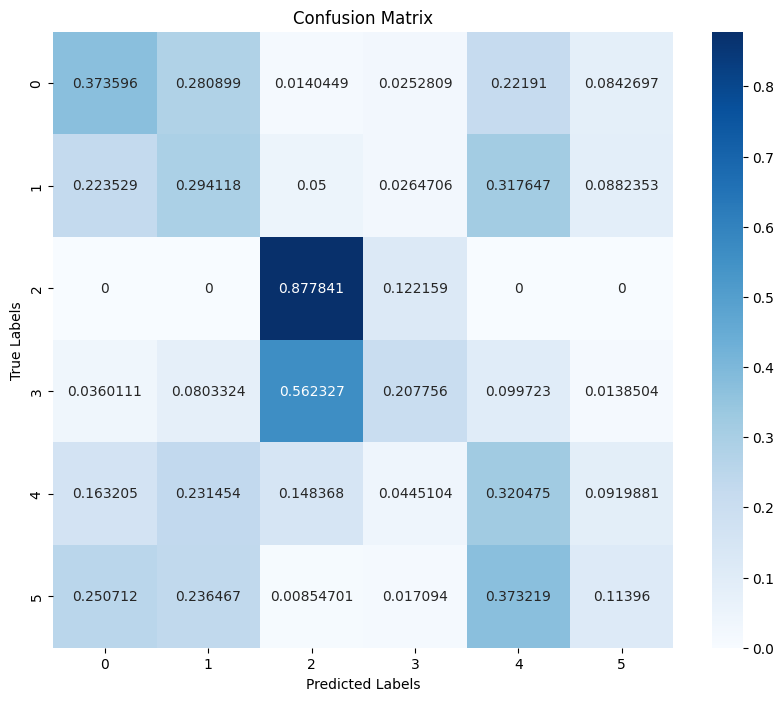

Test Loss: 1.375, Accuracy: 0.365, F1 Score: 0.338, F1 Score Per Class [0.369
Test F1 Score Per Class  [0.36893204 0.2739726  0.65814696 0.28957529 0.27033792 0.16427105]


Epoch 5, Train Loss: 1.3444, Accuracy: 0.3765, F1 Score: 0.3559
Train F1 Score Per Class  [0.38778878 0.21763393 0.63951275 0.2962963  0.27959084 0.32517986]


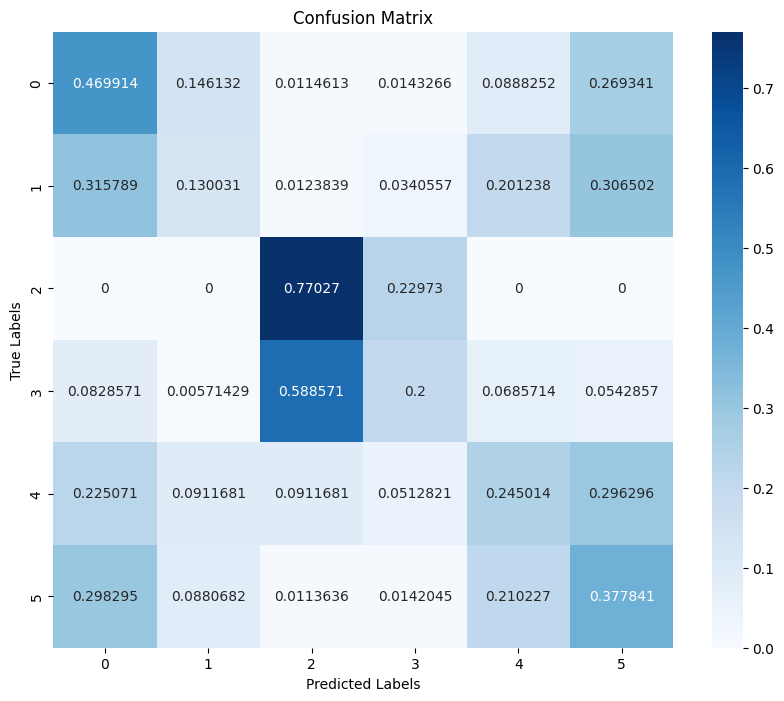

Epoch 5, Validation Loss: 1.3415, Accuracy: 0.3723, F1 Score: 0.3486
Val F1 Score Per Class  [0.39613527 0.17463617 0.62983425 0.25735294 0.2725832  0.33208489]


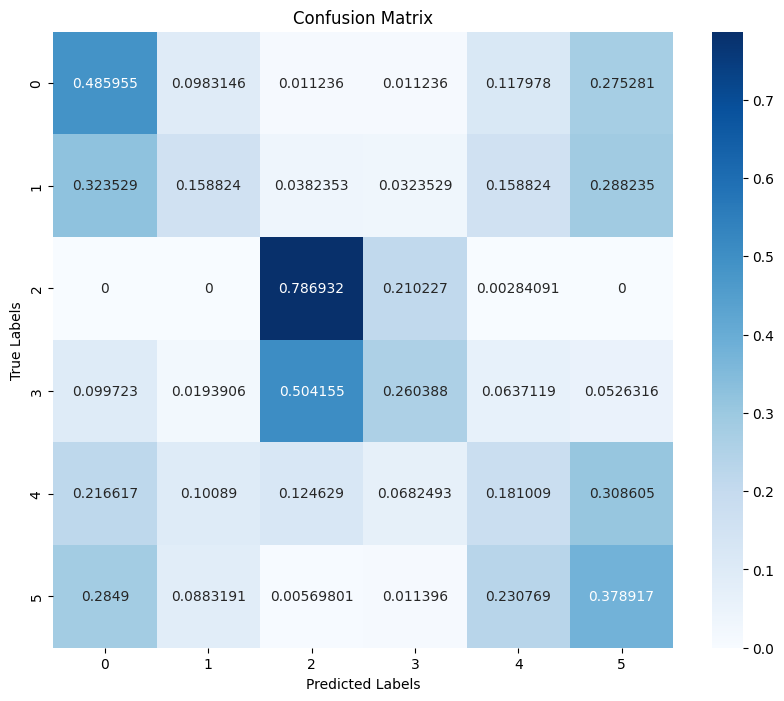

Test Loss: 1.368, Accuracy: 0.378, F1 Score: 0.356, F1 Score Per Class [0.408
Test F1 Score Per Class  [0.40801887 0.21556886 0.6353211  0.32924694 0.20367279 0.33125778]


Epoch 6, Train Loss: 1.3264, Accuracy: 0.3926, F1 Score: 0.3717
Train F1 Score Per Class  [0.41701418 0.22043628 0.63916731 0.30325353 0.28304668 0.37867647]


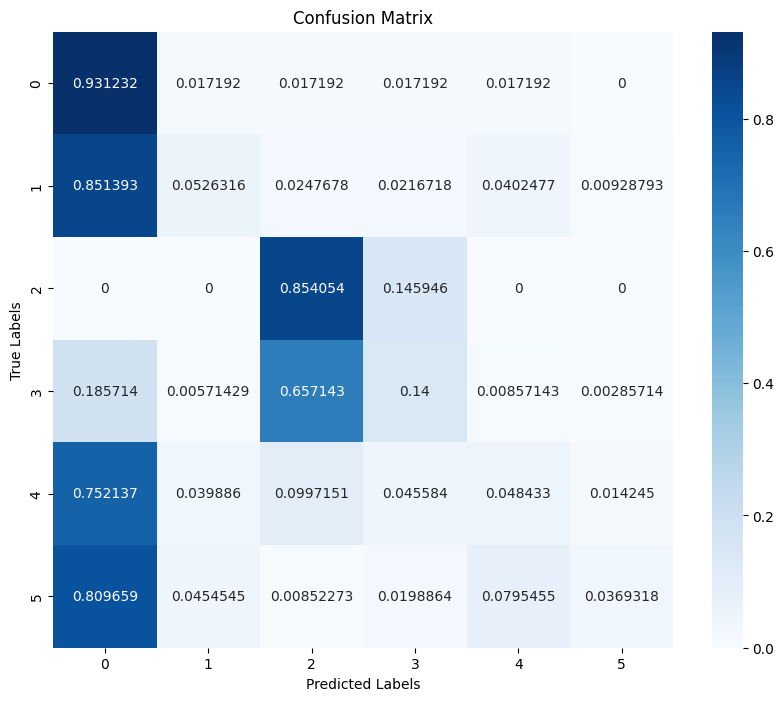

Epoch 6, Validation Loss: 1.3696, Accuracy: 0.3518, F1 Score: 0.2572
Val F1 Score Per Class  [0.41586692 0.08994709 0.65289256 0.200409   0.08133971 0.06951872]


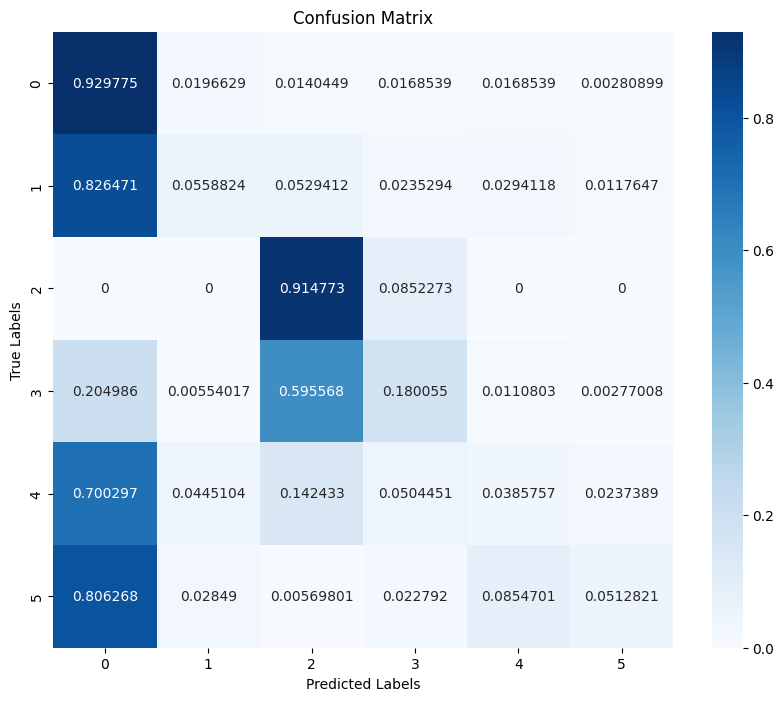

Test Loss: 1.390, Accuracy: 0.366, F1 Score: 0.271, F1 Score Per Class [0.424
Test F1 Score Per Class  [0.42408712 0.09669211 0.66943867 0.26262626 0.065      0.09399478]


Epoch 7, Train Loss: 1.3029, Accuracy: 0.4040, F1 Score: 0.3853
Train F1 Score Per Class  [0.43988741 0.25232114 0.65188119 0.34474616 0.2601798  0.37371855]


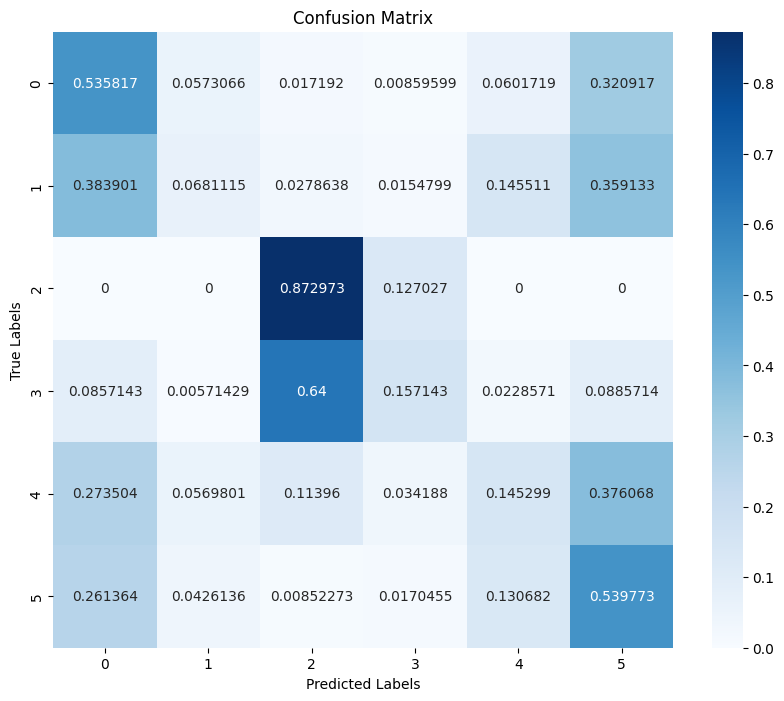

Epoch 7, Validation Loss: 1.3167, Accuracy: 0.3952, F1 Score: 0.3443
Val F1 Score Per Class  [0.42596811 0.10945274 0.6625641  0.23012552 0.19465649 0.40728832]


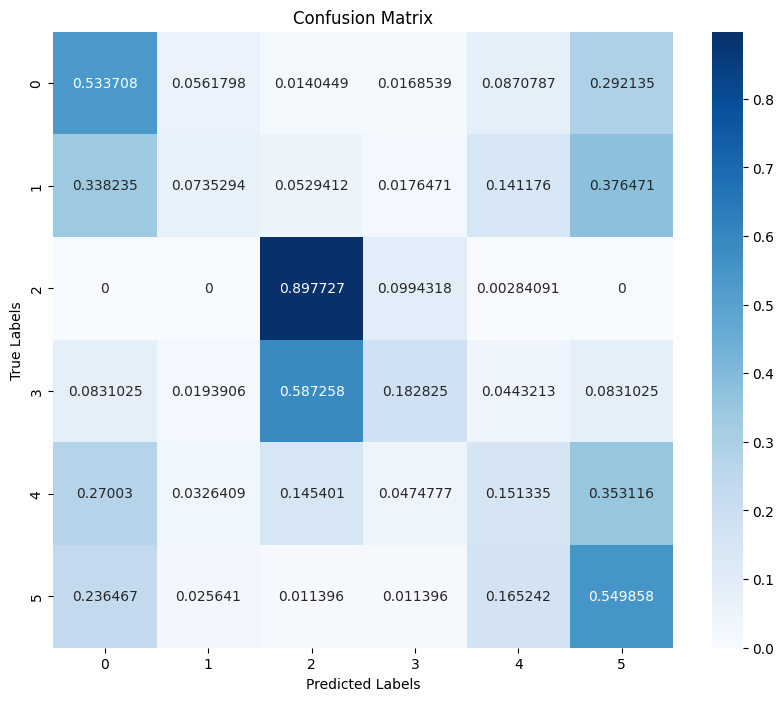

Test Loss: 1.338, Accuracy: 0.401, F1 Score: 0.351, F1 Score Per Class [0.439
Test F1 Score Per Class  [0.43930636 0.12135922 0.66108787 0.26720648 0.18819188 0.4172973 ]


Epoch 8, Train Loss: 1.2762, Accuracy: 0.4264, F1 Score: 0.4095
Train F1 Score Per Class  [0.44896194 0.29197861 0.65188119 0.34507463 0.296875   0.43309859]


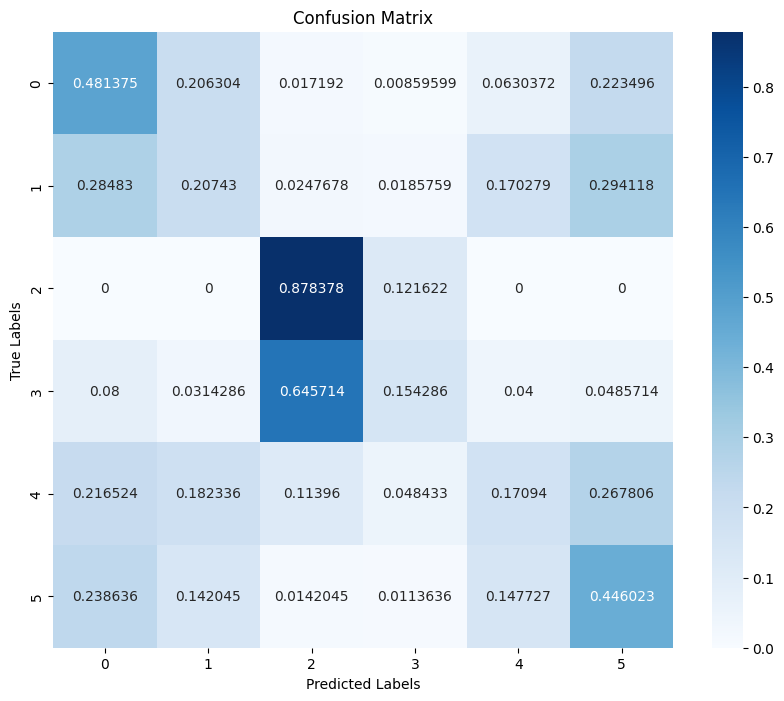

Epoch 8, Validation Loss: 1.3042, Accuracy: 0.3967, F1 Score: 0.3631
Val F1 Score Per Class  [0.42158093 0.22827939 0.66326531 0.22546973 0.2166065  0.39596469]


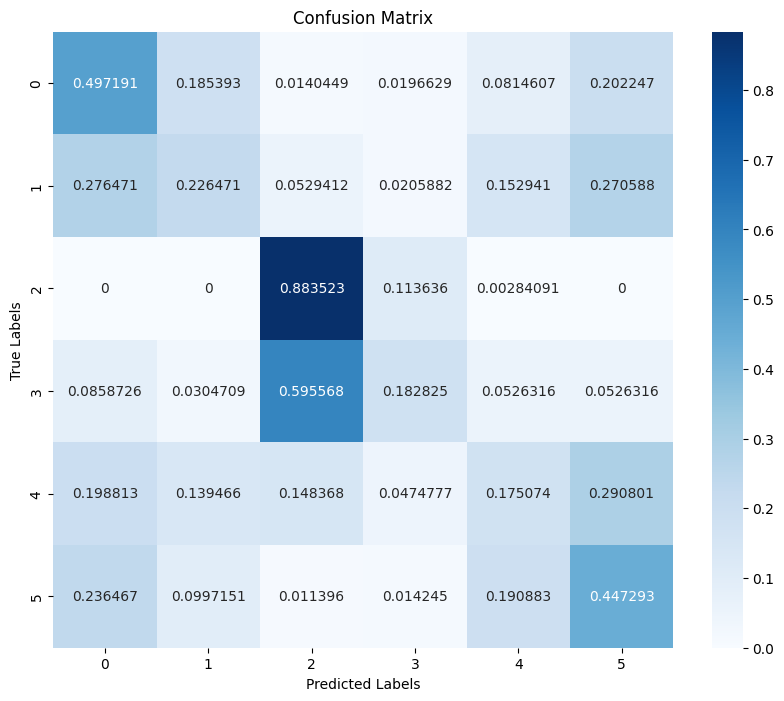

Test Loss: 1.328, Accuracy: 0.404, F1 Score: 0.373, F1 Score Per Class [0.438
Test F1 Score Per Class  [0.43811881 0.26736111 0.6513089  0.26294821 0.20921986 0.39797212]


Epoch 9, Train Loss: 1.2572, Accuracy: 0.4376, F1 Score: 0.4200
Train F1 Score Per Class  [0.47565704 0.2960251  0.66057234 0.36932153 0.28292683 0.44726477]


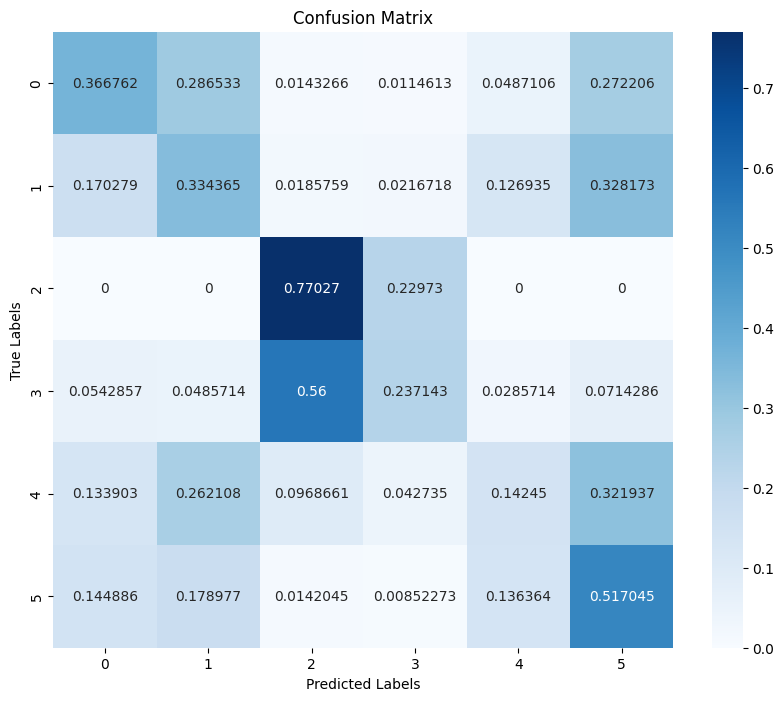

Epoch 9, Validation Loss: 1.3056, Accuracy: 0.3990, F1 Score: 0.3780
Val F1 Score Per Class  [0.394453   0.30725462 0.63263041 0.30347349 0.1934236  0.41695304]


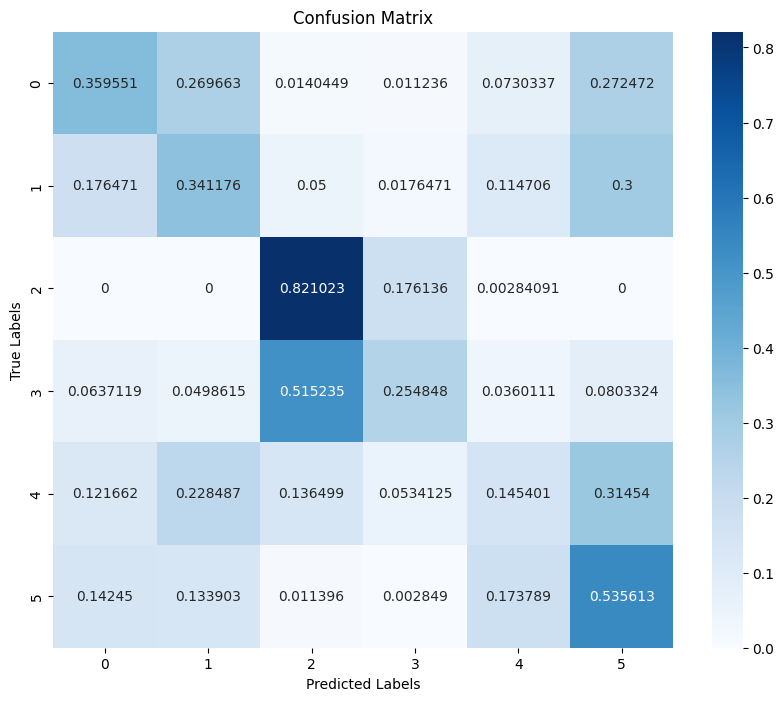

Test Loss: 1.328, Accuracy: 0.411, F1 Score: 0.388, F1 Score Per Class [0.389
Test F1 Score Per Class  [0.38905775 0.33429395 0.6429366  0.33823529 0.18631179 0.43069874]


Epoch 10, Train Loss: 1.2437, Accuracy: 0.4489, F1 Score: 0.4309
Train F1 Score Per Class  [0.48216704 0.3294347  0.67529412 0.380085   0.27195467 0.45714286]


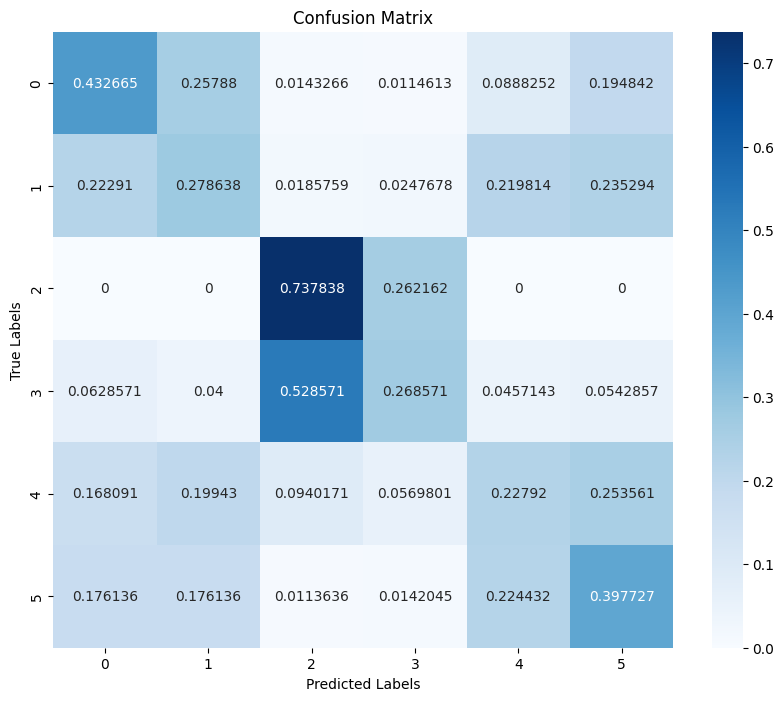

Epoch 10, Validation Loss: 1.3000, Accuracy: 0.3952, F1 Score: 0.3835
Val F1 Score Per Class  [0.42237762 0.27734977 0.62328767 0.32525952 0.25477707 0.37634409]


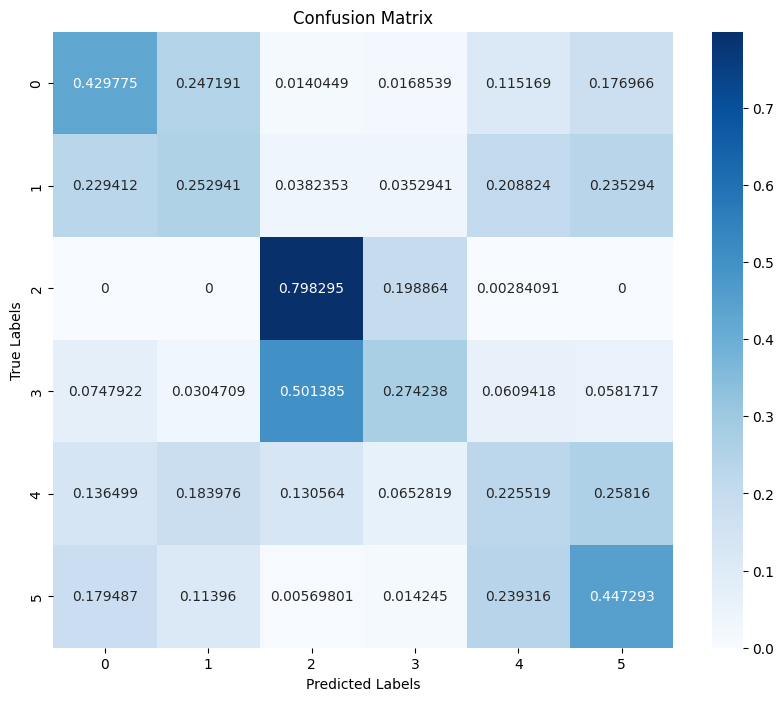

Test Loss: 1.324, Accuracy: 0.406, F1 Score: 0.391, F1 Score Per Class [0.423
Test F1 Score Per Class  [0.42323651 0.27432217 0.64009112 0.34434783 0.24050633 0.41370224]


In [26]:
imagesRoot = '/kaggle/input/blurred-trees-augmented-ver2/blurred_trees'
path_to_images = imagesRoot 
train_loader, val_loader, test_loader = load_data(path_to_images)

class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()
        # Define convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3= nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,stride=1,padding=1)
        
        # Calculate input size for fully connected layers
        self._calculate_conv_output_size()
        
        # Define fully connected layers
        self.fc1 = nn.Linear(self.fc_input_size, 64)
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        # Apply convolutional layers
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        # Flatten the feature map
        x = x.view(x.size(0), -1)
        
        # Apply fully connected layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def _calculate_conv_output_size(self):
        # Forward pass to calculate the output size after convolutional layers
        with torch.no_grad():
            x = torch.zeros(1, 3, 224, 224)  # Input image size is 224x224
            x = self.conv1(x)
            x = F.max_pool2d(x, kernel_size=2, stride=2)
            x = self.conv2(x)
            x = F.max_pool2d(x, kernel_size=2, stride=2)
            x = self.conv3(x)
            x = F.max_pool2d(x, kernel_size=2, stride=2)
            self.fc_input_size = x.size(1) * x.size(2) * x.size(3)
num_classes = 6  
num_epochs = 10
# Load the pretrained ResNet-50 model
model = models.resnet50(weights="DEFAULT")

model.fc = nn.Linear(model.fc.in_features, num_classes)
# Load CNN model
cnn_model = CustomCNN(num_classes=num_classes)

# Initialize best F1 score for validation
best_val_f1 = 0.0
best_model_weights = None
model_name_1 = 'ResNet50'
model_name_2 = 'CustomCNN'
#trained_model_1 = train_and_evaluate(model, train_loader, val_loader, test_loader, model_name_1, num_epochs) #For ResNet50
trained_model_2 = train_and_evaluate(cnn_model, train_loader, val_loader, test_loader, model_name_2, num_epochs) #For custom CNN